# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
# # Run this to use from colab environment
# !git clone https://github.com/jveenland/tm10007_ml.git

# import zipfile
# import os
# import pandas as pd

# with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/tm10007_ml/ecg')

# data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

# print(f'The number of samples: {len(data.index)}')
# print(f'The number of columns: {len(data.columns)}')

In [1]:
# Run this to use from colab environment
# !git clone https://github.com/jveenland/tm10007_ml.git

# General packages
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Scikit-learn utilities and metrics
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, learning_curve, cross_val_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_selection import RFECV, SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve 
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from scipy.stats import zscore
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.metrics import auc
import sklearn
import seaborn as sns

# Load data
with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Set RandomState for the entire script
np.random.seed(42)

The number of samples: 827
The number of columns: 9001


In [59]:
# Load functions
def plot_learning_curve(X_train, y_train, classifier, scoring, clf_type):
    '''
    This function plots the learning curve of a classifier using a 5-fold cross-validation
    Inputs:
    - X_train: 
    - y_train: labels
    - classifier: fitted classifier
    - scoring: supports all scoring methods from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html 
    and the 'error' scoring method, which is 1-accuracy
    - clf_type: is used for the title of the plot
    '''
    if scoring == 'error':
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='accuracy',
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1,
        )
        train_scores_mean = 1-np.mean(train_scores, axis=1) # error = 1 - accuracy
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = 1-np.mean(test_scores, axis=1) # error = 1 - accuracy
        test_scores_std = np.std(test_scores, axis=1)
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1,
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

    # Plot figure
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve ({clf_type})")
    plt.xlabel("Number of training objects")
    plt.ylabel(scoring)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="blue")

    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="green")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

def plot_roc_cv(X, y, hyperparams_function, n_splits=5):
    '''
    Performs a cross validation to train a number of models (equal to n_splits), calculates relevant metrics and plots the mean ROC curve.
    Returns the best classifier out of the folds with the corresponding training data
    '''
    y = data.iloc[:,-1]
    X = data.iloc[:,:-1]

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    tprs = []
    aucs = []
    best_classifier = None
    best_auc = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        classifier = hyperparams_function(X_train, y_train)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        if viz.roc_auc > best_auc:
            best_auc = viz.roc_auc
            best_classifier = classifier
            best_X_train = X_train
            best_y_train = y_train

        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        fold_auc = roc_auc_score(y_test, y_proba)

        print(f"Accuracy:  {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall:    {recall:.3f}")
        print(f"F1 Score:  {f1:.3f}")
        print(f"AUC Score: {fold_auc:.3f}")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability",
    )
    ax.legend(loc="lower right")
    plt.show()
    return best_X_train, best_y_train, best_classifier


# Data visualisation

(207, 9000)
(620, 9000)


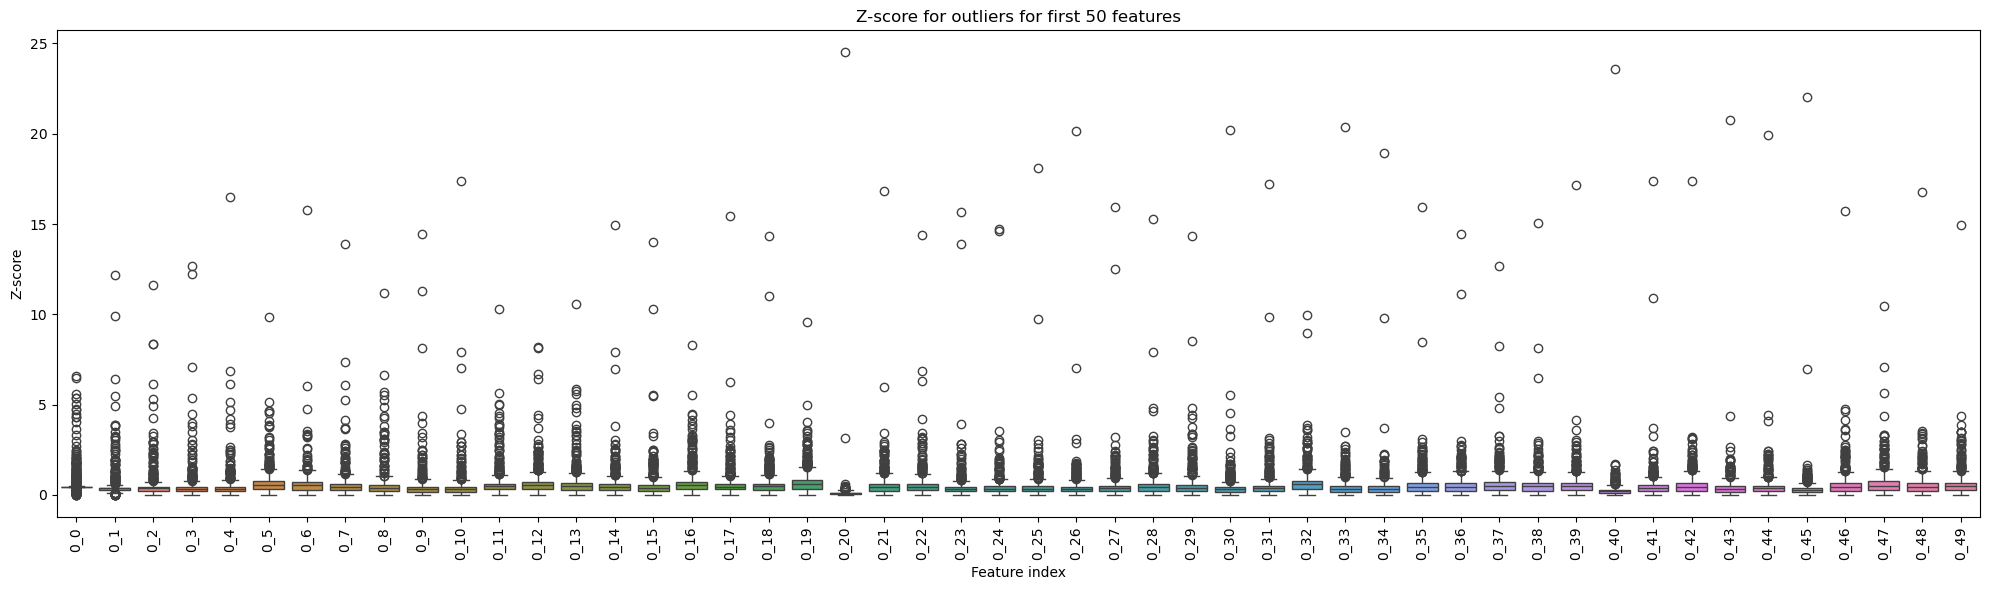

In [2]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)
print(X_test.shape)
print(X_train.shape)

#Preprocessing, scaling: outliers plotten for first 50 features
X_subset = X_train.iloc[:, :50]
z_scores = np.abs(zscore(X_subset))

plt.figure(figsize=(20, 6))
sns.boxplot(data=pd.DataFrame(z_scores, columns=X_subset.columns))
plt.title("Z-score for outliers for first 50 features")
plt.xlabel("Feature index")
plt.ylabel("Z-score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# SVM

In [ ]:
# Split data in test and train, do this once
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

With this code, a learning curve for robust and powertransform was made to make a choise between the scaling/transforming method

In [ ]:
# Powertransform
# ====== PIPELINE CHARACTERISTICS ======
svm_feature = SVC(kernel="linear", random_state=42, class_weight='balanced')

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('select_k_best', SelectKBest(mutual_info_classif, k=60)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced'))
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_train, y_train)
plot_learning_curve(X_train, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=60, powertransform')
print("Gemiddelde ROC AUC:", scores.mean())


# robust scaling
# ====== PIPELINE CHARACTERISTICS ======
cv = StratifiedKFold(n_splits=5)
svm_feature = SVC(kernel="linear", random_state=42, class_weight='balanced')

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('select_k_best', SelectKBest(mutual_info_classif, k=60)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced'))
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_train, y_train)
plot_learning_curve(X_train, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=60, robust')
print("Gemiddelde ROC AUC:", scores.mean())

To select the best k for SelectKBest, a learning curve is plotted for K=100, K=80, K=60, K=40 and K=20. In addition, the number of selected features after RFECV and the mean ROC AUC is printed. This is done with transformation and feature selection outside the pipeline, for computational reasons. 

In [ ]:
# ====== Powertransformation ======
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

In [ ]:
# K = 100
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=100)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=100')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

In [ ]:
# K = 80
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=80)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=80')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

In [ ]:
# K = 60
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=60')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

In [ ]:
# K = 40 
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=40)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=40')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

In [ ]:
# K = 20
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for fe5ature selection
selector = SelectKBest(mutual_info_classif, k=20)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=20')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

Since K=20 gave the best learning curve, also a learning curve for K=25 and K=15 are made. 

In [ ]:
#K=25
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=25)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=25')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

In [ ]:
# K = 15
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=15)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=15')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

In [ ]:
#K

# KNN

In [ ]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)
print(X_test.shape)
print(X_train.shape)

ROC AUC scores per fold: [0.47883244 0.55659537 0.65285205 0.56773619 0.67475728]
Gemiddelde ROC AUC: 0.5861546648668293


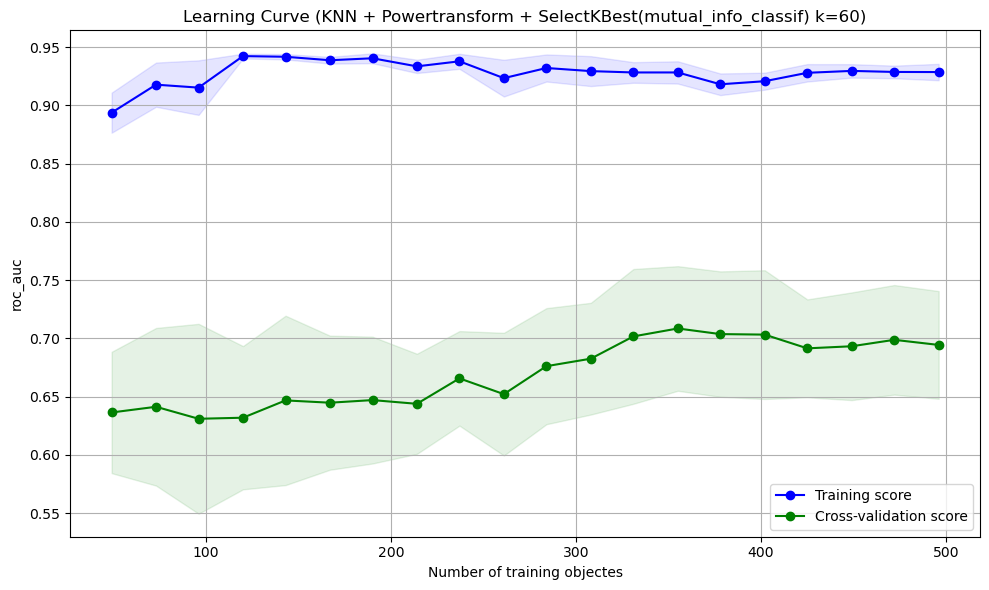

In [ ]:
#choose between Robustscaling and powertransform, met mutual_info_classif, k=60
#Powertransform
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_powertransformer = power_transformer.fit_transform(X_train)
X_test_powertransformer = power_transformer.transform(X_test)

#feature selection with mutual_info_classif, == 60 features
selector = SelectKBest(score_func=mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_powertransformer, y_train)
X_test_reduced = selector.transform(X_test_powertransformer)

knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_powertransformer,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=60')

ROC AUC scores per fold: [0.57954545 0.69875223 0.69451872 0.68226381 0.80189552]
Gemiddelde ROC AUC: 0.6913951458782983


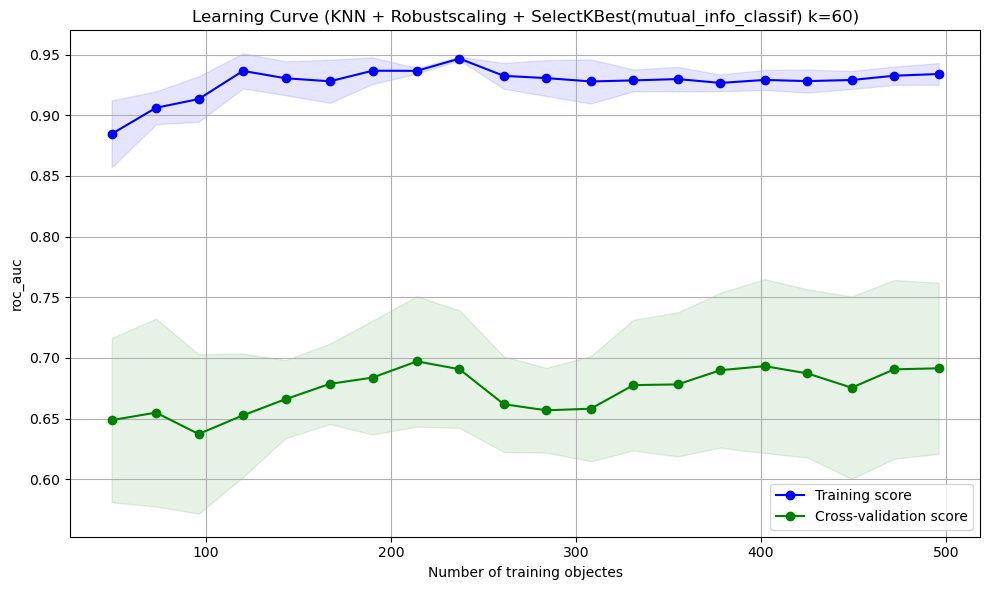

In [ ]:
#choose between Robustscaling and powertransform, met mutual_info_classif, k=60
#RobustScaling
robust_scaling = RobustScaler()
X_train_transformed = robust_scaling.fit_transform(X_train)
X_test_transformed = robust_scaling.transform(X_test)

#feature selection with mutual_info_classif, == 60 features
selector = SelectKBest(score_func=mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Robustscaling + SelectKBest(mutual_info_classif) k=60')

ROC AUC scores per fold: [0.60784314 0.75891266 0.65998217 0.64215686 0.72122053]
Gemiddelde ROC AUC: 0.6780230715410612


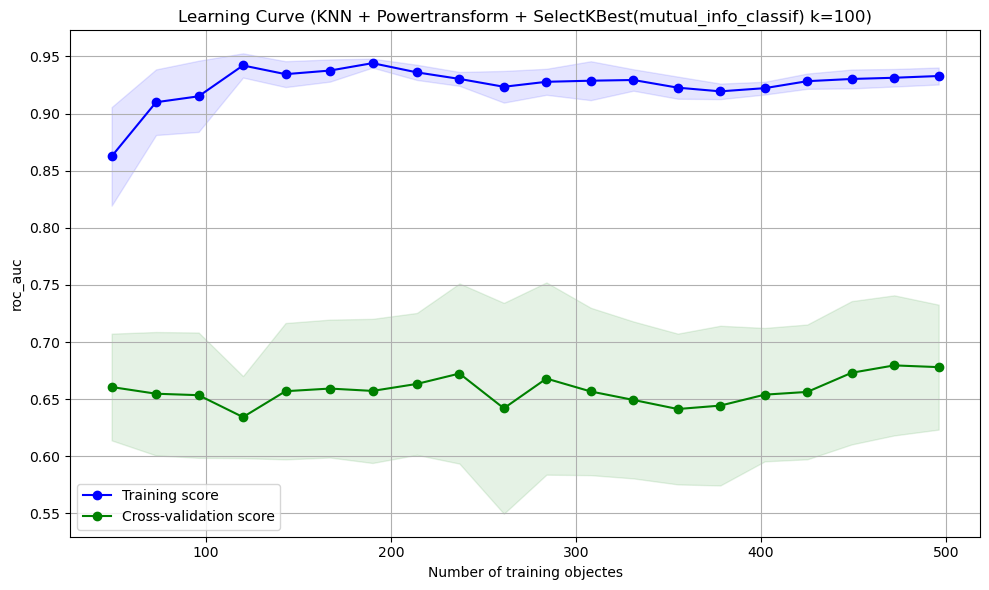

In [ ]:
#Feature selection --> Select the best k=100 
#Powertransform
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_powertransformer = power_transformer.fit_transform(X_train)
X_test_powertransformer = power_transformer.transform(X_test)


#feature selection with mutual_info_classif, == 100 features
selector = SelectKBest(score_func=mutual_info_classif, k=100)
X_train_reduced = selector.fit_transform(X_train_powertransformer, y_train)
X_test_reduced = selector.transform(X_test_powertransformer)

knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=100')

ROC AUC scores per fold: [0.61363636 0.73707665 0.63480392 0.6399287  0.79449838]
Gemiddelde ROC AUC: 0.6839888029351192


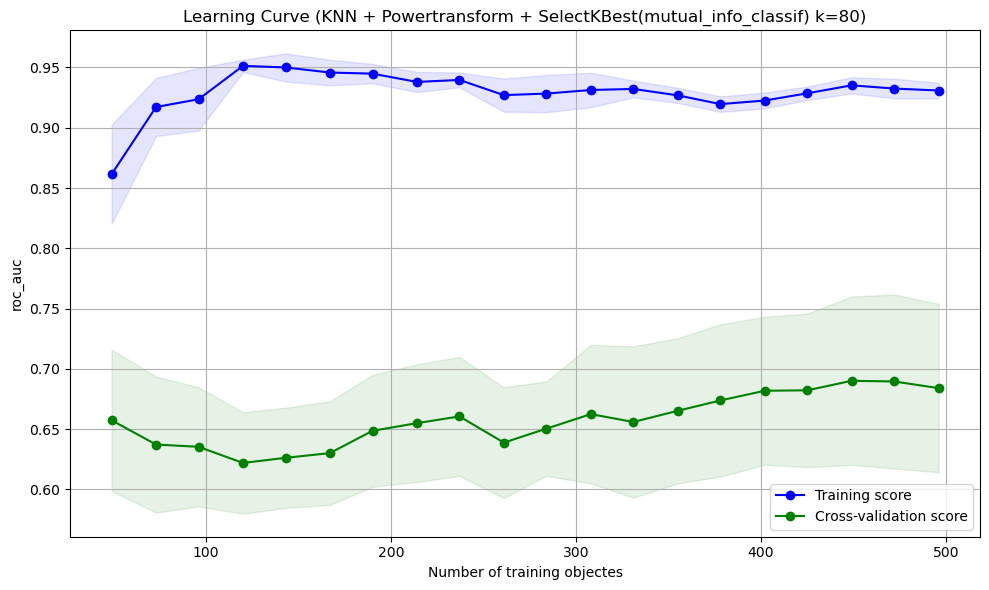

In [ ]:
#Feature selection --> Select the best k=80 
#Powertransform
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_powertransformer = power_transformer.fit_transform(X_train)
X_test_powertransformer = power_transformer.transform(X_test)


#feature selection with mutual_info_classif, == 80 features
selector = SelectKBest(score_func=mutual_info_classif, k=80)
X_train_reduced = selector.fit_transform(X_train_powertransformer, y_train)
X_test_reduced = selector.transform(X_test_powertransformer)

knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=80')

ROC AUC scores per fold: [0.6236631  0.74242424 0.71457219 0.65708556 0.73416551]
Gemiddelde ROC AUC: 0.6943821217807512


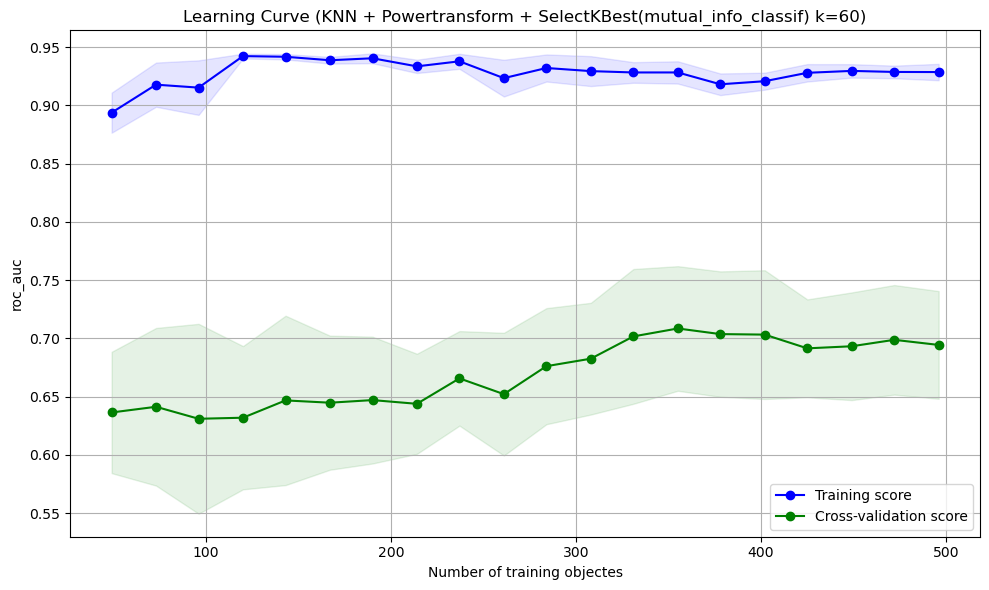

In [ ]:
#Feature selection --> Select the best k=60 
#Powertransform
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_powertransformer = power_transformer.fit_transform(X_train)
X_test_powertransformer = power_transformer.transform(X_test)


#feature selection with mutual_info_classif, == 60 features
selector = SelectKBest(score_func=mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_powertransformer, y_train)
X_test_reduced = selector.transform(X_test_powertransformer)

knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=60')

ROC AUC scores per fold: [0.75579323 0.75668449 0.68493761 0.64215686 0.82177531]
Gemiddelde ROC AUC: 0.7322695009159885


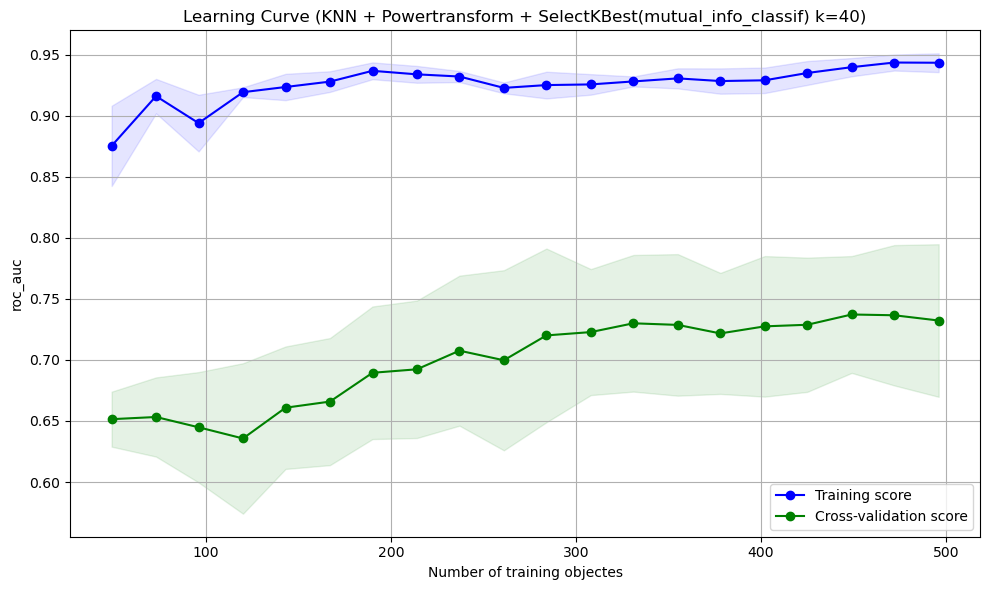

In [ ]:
#Feature selection --> Select the best k=40 
#Powertransform
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_powertransformer = power_transformer.fit_transform(X_train)
X_test_powertransformer = power_transformer.transform(X_test)


#feature selection with mutual_info_classif, == 40 features
selector = SelectKBest(score_func=mutual_info_classif, k=40)
X_train_reduced = selector.fit_transform(X_train_powertransformer, y_train)
X_test_reduced = selector.transform(X_test_powertransformer)

knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=40')

ROC AUC scores per fold: [0.65285205 0.72704991 0.62009804 0.72660428 0.8171521 ]
Gemiddelde ROC AUC: 0.7087512763269473


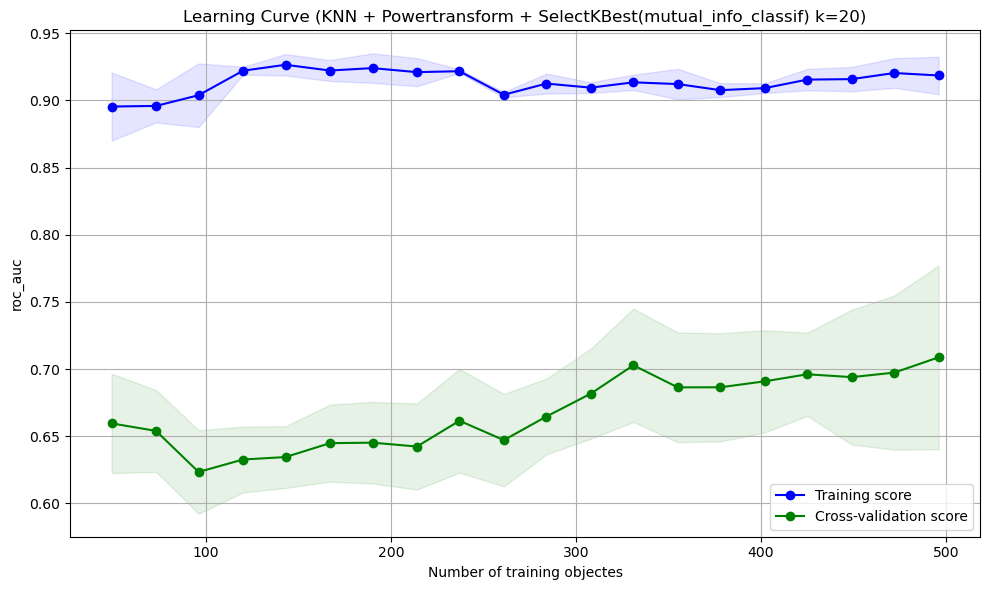

In [ ]:
#Feature selection --> Select the best k=20
#Powertransform
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_powertransformer = power_transformer.fit_transform(X_train)
X_test_powertransformer = power_transformer.transform(X_test)


#feature selection with mutual_info_classif, == 20 features
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_train_reduced = selector.fit_transform(X_train_powertransformer, y_train)
X_test_reduced = selector.transform(X_test_powertransformer)

knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=20')

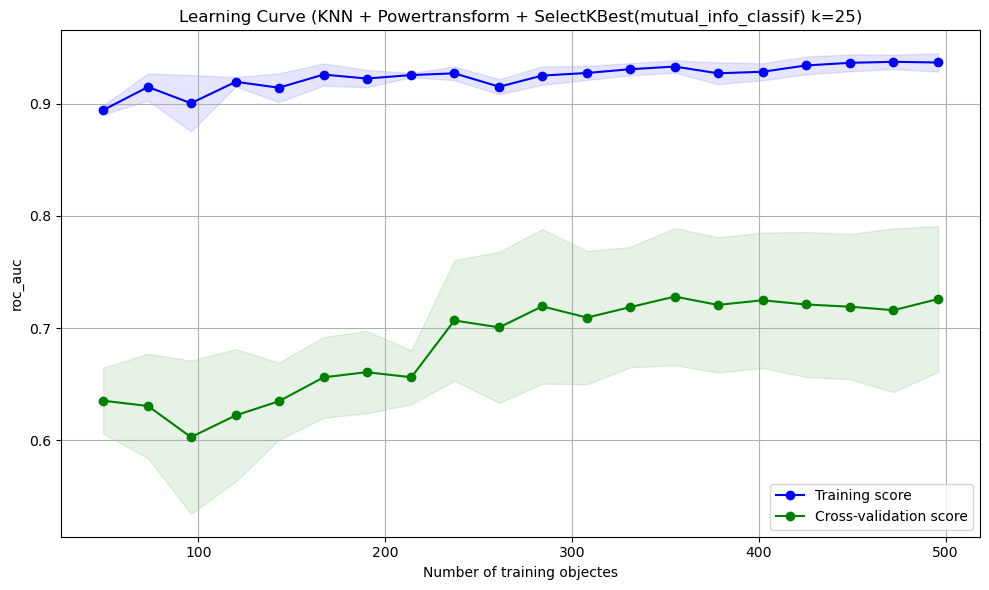

Gemiddelde ROC AUC: 0.7259407116774336


In [ ]:
#Feature selection --> Select the best k=25
#Powertransform
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_powertransformer = power_transformer.fit_transform(X_train)
X_test_powertransformer = power_transformer.transform(X_test)


#feature selection with mutual_info_classif, == 25 features
selector = SelectKBest(score_func=mutual_info_classif, k=25)
X_train_reduced = selector.fit_transform(X_train_powertransformer, y_train)
X_test_reduced = selector.transform(X_test_powertransformer)

knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=25')
print("Gemiddelde ROC AUC:", scores.mean())

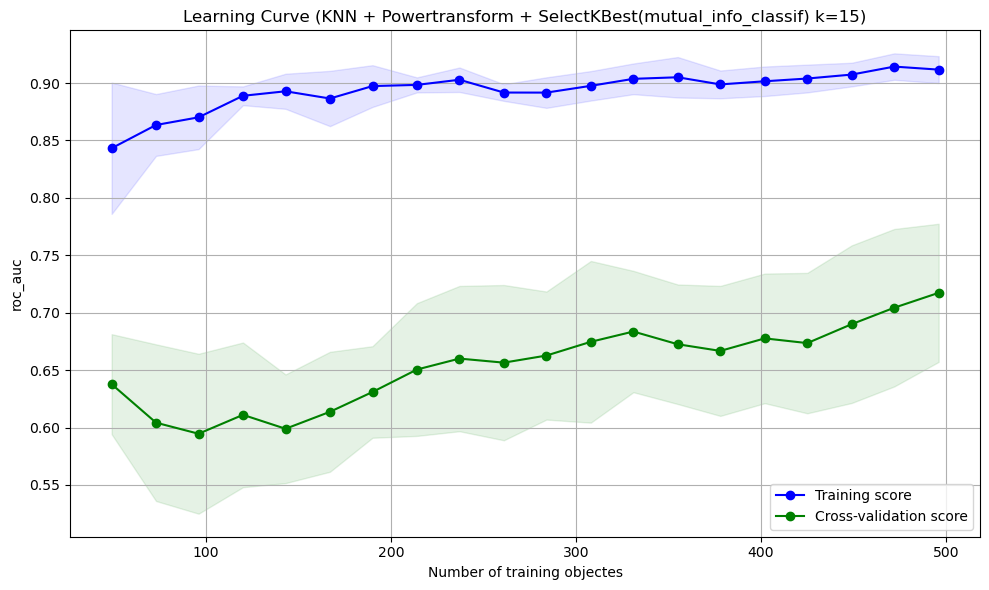

Gemiddelde ROC AUC: 0.7172785001026006


In [ ]:
#Feature selection --> Select the best k=15
#Powertransform
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_powertransformer = power_transformer.fit_transform(X_train)
X_test_powertransformer = power_transformer.transform(X_test)


#feature selection with mutual_info_classif, == 15 features
selector = SelectKBest(score_func=mutual_info_classif, k=15)
X_train_reduced = selector.fit_transform(X_train_powertransformer, y_train)
X_test_reduced = selector.transform(X_test_powertransformer)

knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])

knn.fit(X_train_reduced, y_train) 

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=15')
print("Gemiddelde ROC AUC:", scores.mean())

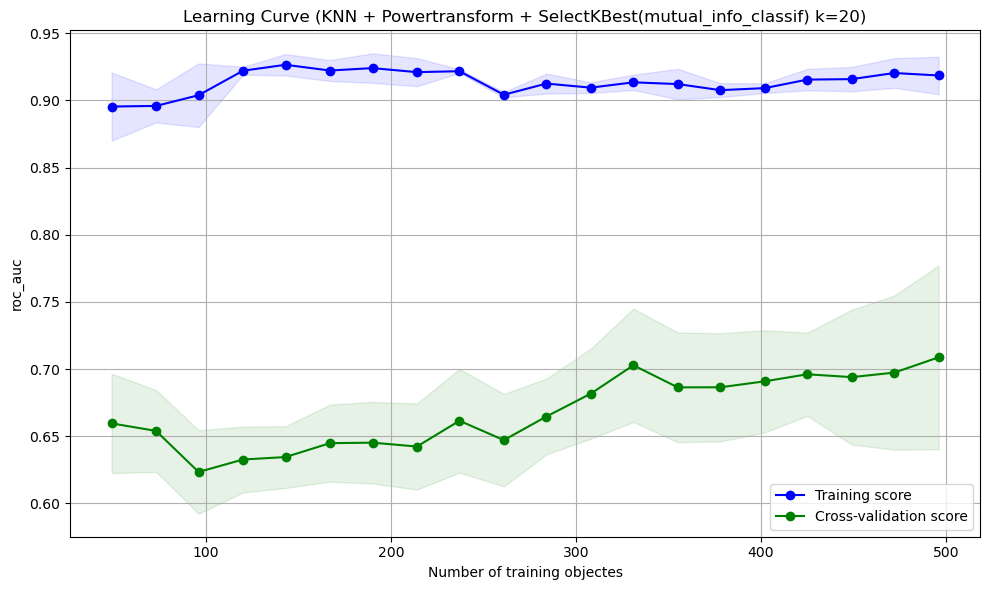

Gemiddelde ROC AUC: 0.7087512763269473


In [ ]:
#Feature selection --> Select the best k=20
#Powertransform
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_powertransformer = power_transformer.fit_transform(X_train)
X_test_powertransformer = power_transformer.transform(X_test)


#feature selection with mutual_info_classif, == 20 features
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_train_reduced = selector.fit_transform(X_train_powertransformer, y_train)
X_test_reduced = selector.transform(X_test_powertransformer)

knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(mutual_info_classif) k=20')
print("Gemiddelde ROC AUC:", scores.mean())

Best estimator: Pipeline(steps=[('scaler', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=25,
                             score_func=<function mutual_info_classif at 0x0000018F2C541A80>)),
                ('classifier', KNeighborsClassifier(n_neighbors=21))])
Best ROC_AUC Score: 0.6926581223839933
best parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 21, 'classifier__metric': 'minkowski'}


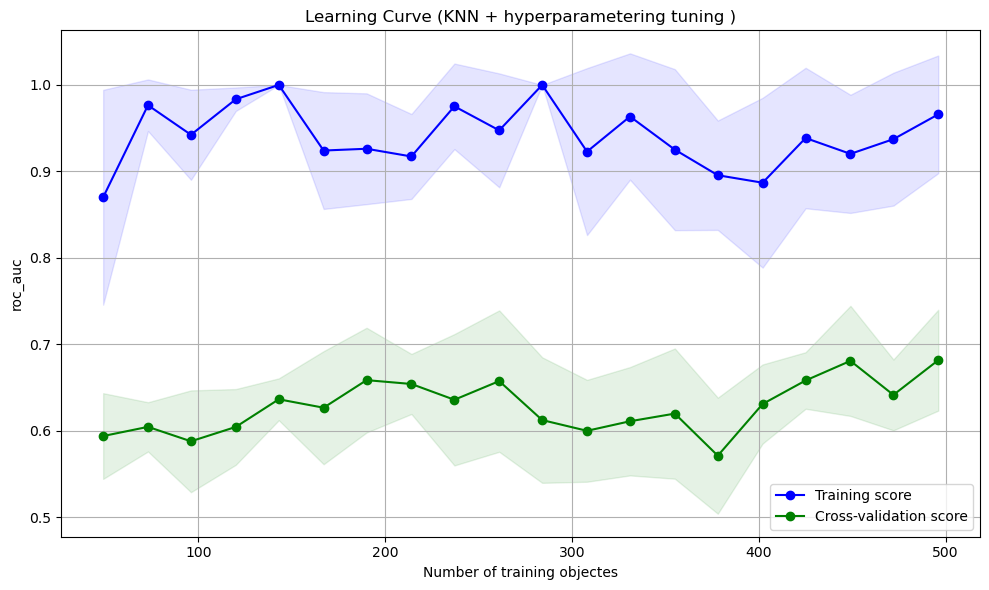

In [ ]:
#Hyperparameter tuning
knn = Pipeline([
    ('scaler', PowerTransformer(method='yeo-johnson')),
    ('feature_selection', SelectKBest(mutual_info_classif, k=25)),
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=10,
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc'  
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best ROC_AUC Score:", model.best_score_)
print("best parameters:", model.best_params_)

plot_learning_curve(X_train, y_train, classifier=model, scoring='roc_auc', clf_type='KNN + hyperparametering tuning ')

In [ ]:
def optimize_knn(X_train, y_train):
    pipe = Pipeline([
        ('scaler', PowerTransformer(method='yeo-johnson')),
        ('feature_selection', SelectKBest(mutual_info_classif, k=25)),
        ('classifier', KNeighborsClassifier())
    ])

    param_dist = {
        'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)
 
    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_    



Best Parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 21, 'classifier__metric': 'euclidean'}
Best Score: 0.7028792375176666
Accuracy:  0.861
Precision: 1.000
Recall:    0.207
F1 Score:  0.343
AUC Score: 0.768
Best Parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 19, 'classifier__metric': 'minkowski'}
Best Score: 0.7785666799627708
Accuracy:  0.855
Precision: 1.000
Recall:    0.200
F1 Score:  0.333
AUC Score: 0.682
Best Parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 15, 'classifier__metric': 'euclidean'}
Best Score: 0.6865958649115809
Accuracy:  0.848
Precision: 1.000
Recall:    0.138
F1 Score:  0.242
AUC Score: 0.788
Best Parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 11, 'classifier__metric': 'euclidean'}
Best Score: 0.7358928333998138
Accuracy:  0.861
Precision: 0.750
Recall:    0.310
F1 Score:  0.439
AUC Score: 0.680
Best Parameters: {'classifier__weights': 'distance', 'classifi

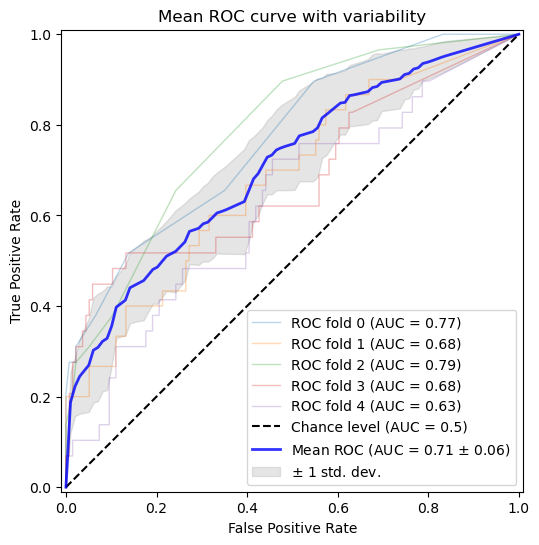

In [ ]:
#Perform hyperparameter optimization and plot mean ROC curve with variability
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, optimize_knn, n_splits=5)

### Unused code KNN:

In [ ]:
#Optie 1: Feature selection with SelectKBest mutual_info_classif, k=100

knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])


scores = cross_val_score(
    knn,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train, y_train, classifier=knn, scoring='error', clf_type='KNN + SelectKBest(mutual_info_classif) k=100')


In [ ]:

#Optie 2: Feature selection: pre-feature selection (f_classif, k=200) and with SelectKBest mutual_info_classif, k=100
selector = SelectKBest(score_func=f_classif, k=200)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])


scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='error', clf_type='KNN + pre-feature selection (f_classif, k=200)+ SelectKBest(mutual_info_classif) k=100 ')



In [ ]:
#Optie 3: Feature selection with SelectKBest f_classif, k=100
knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])


scores = cross_val_score(
    knn,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train, y_train, classifier=knn, scoring='error', clf_type='KNN + SelectKBest f_classif, k=100')

In [ ]:
#Optie 2: Feature selection: pre-feature selection (f_classif, k=200) and with SelectKBest mutual_info_classif, k=100
#hyperparameter tuning with RandomizedSearchCV

selector = SelectKBest(score_func=f_classif, k=200)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=10,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc' ,
    random_state=42 
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best ROC_AUC Score:", model.best_score_)
print("best parameters:", model.best_params_)

plot_learning_curve(X_train, y_train, classifier=knn, scoring='error', clf_type='KNN + hyperparameter tuning with RandomizedSearchCV + pre-feature selection (f_classif, k=200)+ SelectKBest(mutual_info_classif) k=100 ')


# Random Forest

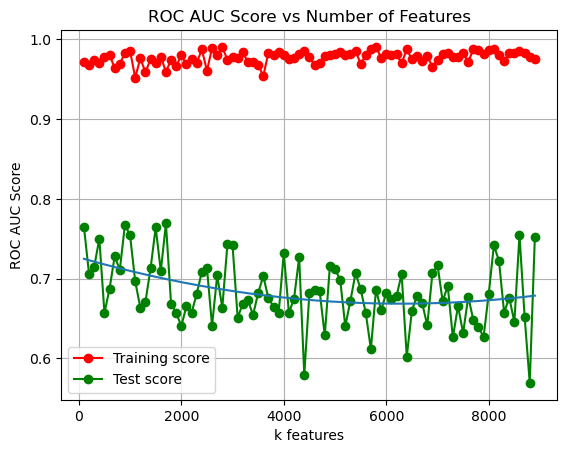

In [48]:
# Since the dataset contains 9000 features, it is likely that a large part of the features in the dataset contains no useful information. 
# If RF randomly selects these irrelevant features, we would introduce noise to our model and thus decrease the model performance. 
# To test this, the area under the receiver operating characteristics curve (ROC AUC) score was plotted for different numbers of features, 
# using a simple RF classifier (n_estimators=10, max_depth=10) and a train-test-split (test size 0.25).

labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

train_scores = []
test_scores = []
k_list = np.arange(100,9000,100)

# For each k features in the list, train a RF classifier and calculate the AUC score
for k in k_list:
    rf = Pipeline([
                ('feature_selection', SelectKBest(f_classif, k=k)), 
                ('rfc', RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1, random_state=42))
                ])
    rf.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
    test_scores.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# Fit a trendline through the points of the test scores (since that is what we're interested in)
poly = np.polyfit(k_list, test_scores, deg=2)
poly_func = np.poly1d(poly)

k_smooth = np.linspace(k_list.min(), k_list.max(), 300)
test_scores_smooth = poly_func(k_smooth)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.plot(k_list, train_scores, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores, 'o-', color="g",
        label="Test score")
ax.plot(k_smooth, test_scores_smooth)
ax.set_title('ROC AUC Score vs Number of Features')
ax.set_xlabel('k features')
ax.set_ylabel('ROC AUC Score')
ax.legend()


In [60]:
# For the Random Forest classifier, we decided to optimize the number of features (k), the number of estimators (n_estimators),
# minimum number of samples required for a split (min_samples_split), minimum number of samples required for a leaf (min_samples_leaf), 
# maximum depth of each tree (max_depth), function to measure the quality of a split (criterion), 
# and whether bootstrapping is used to train the trees (bootstrap).

def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(50, 250, 10),
        'classifier__n_estimators': np.arange(5, 15, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_


Best Parameters: {'feature_selection__k': 140, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 45, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.7872425110923981
Accuracy:  0.789
Precision: 0.421
Recall:    0.552
F1 Score:  0.478
AUC Score: 0.765
Best Parameters: {'feature_selection__k': 160, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}
Best Score: 0.8013429065283871
Accuracy:  0.729
Precision: 0.358
Recall:    0.633
F1 Score:  0.458
AUC Score: 0.773
Best Parameters: {'feature_selection__k': 180, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.8123337986969817

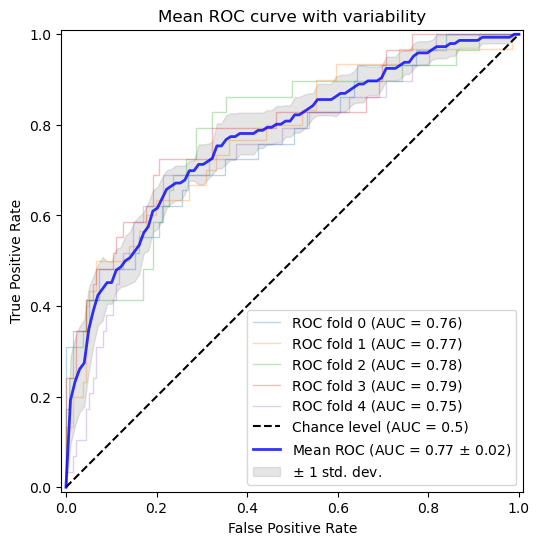

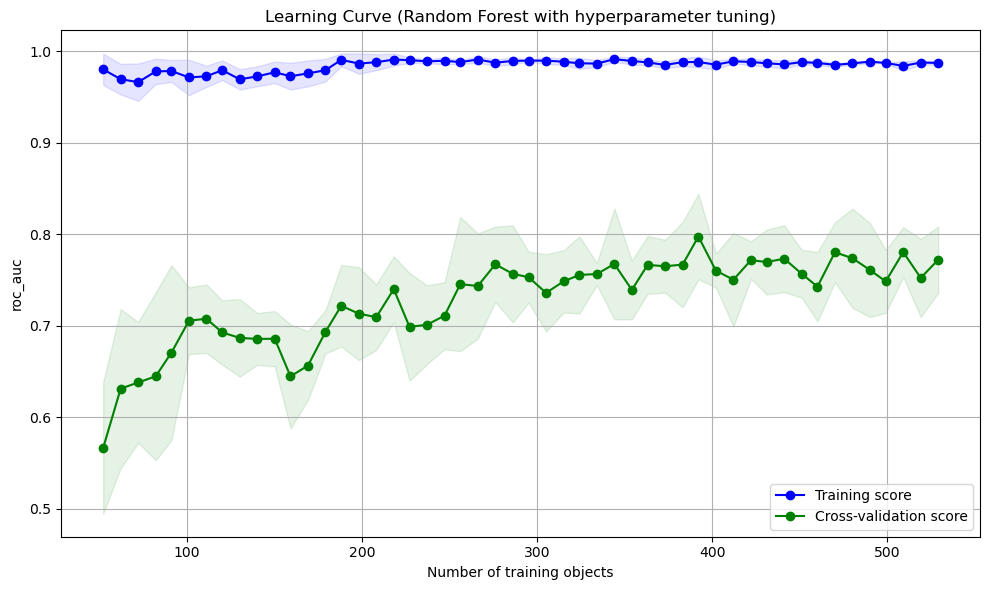

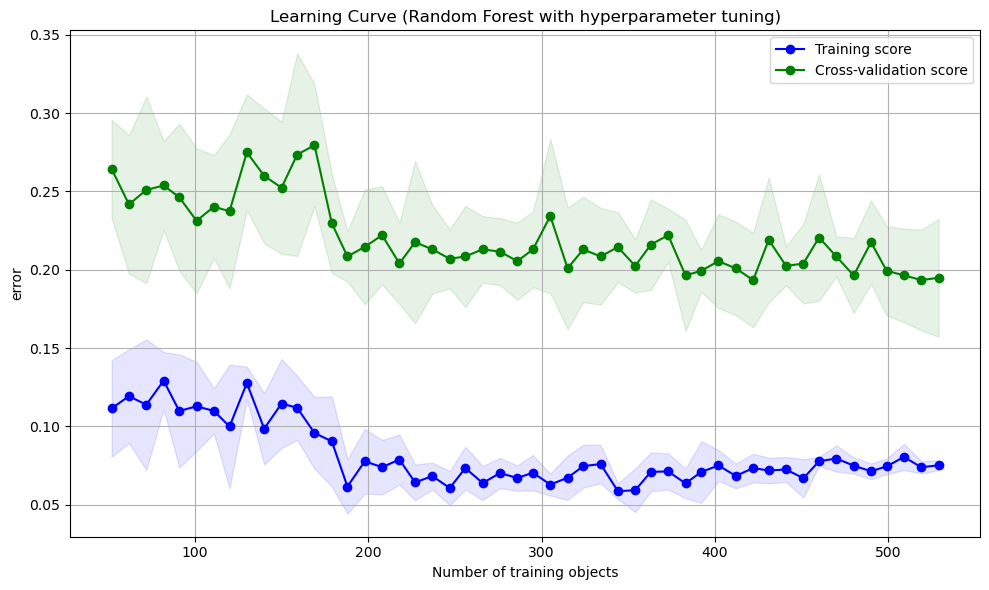

In [61]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, optimize_rf, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')


## Unused Code for Random Forest

### Baseline RandomForest model
To check the performance of a simple model, a RandomForestClassifier with 10 estimators and a max depth of 5 was used. The same model was used to plot the AUC score vs the number of features.
The learning curves show a gradual decrease in the cross-validation error, but a fast increase in training error. This indicates that the model can be optimised to improve the performance.

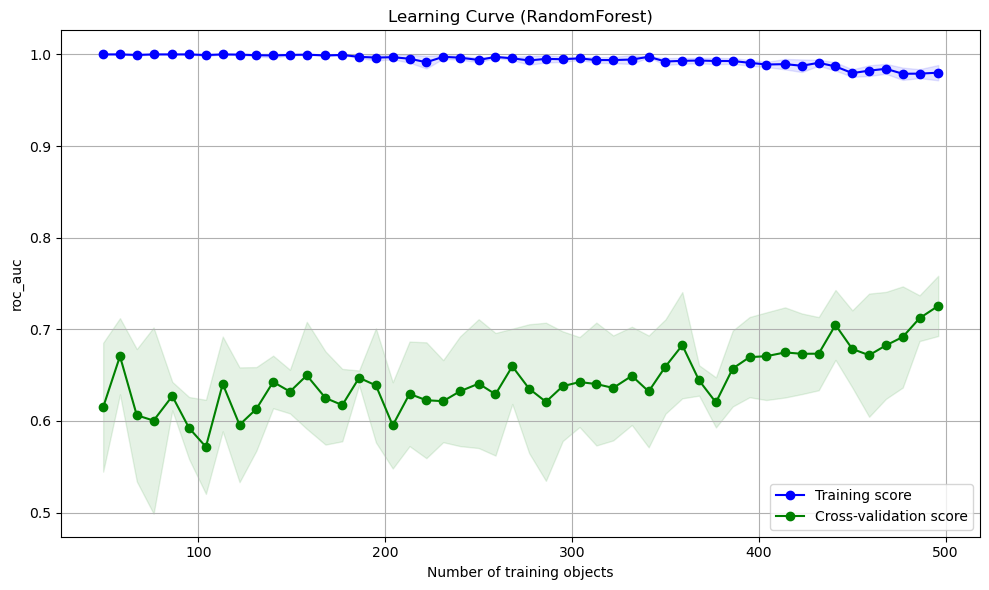

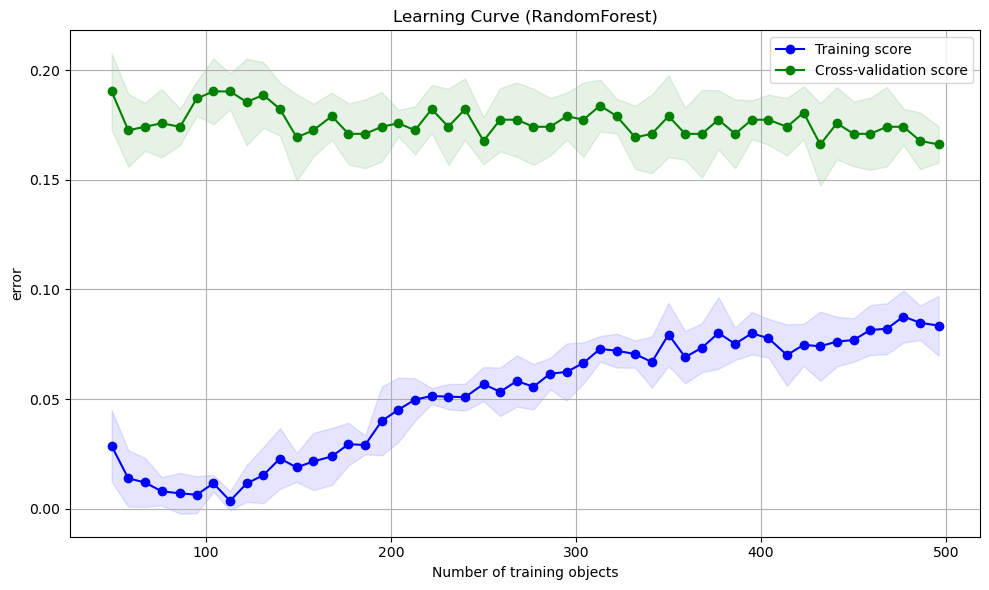

In [58]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

rf = RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

plot_learning_curve(X_train, y_train, rf, scoring='roc_auc', clf_type='RandomForest')
plot_learning_curve(X_train, y_train, rf, scoring='error', clf_type='RandomForest')

Best Parameters: {'feature_selection__k': 1950, 'classifier__n_estimators': 38, 'classifier__min_samples_split': 14, 'classifier__min_samples_leaf': 14, 'classifier__max_depth': 16, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.8001016290189937
Accuracy:  0.843
Precision: 0.588
Recall:    0.345
F1 Score:  0.435
AUC Score: 0.782
Best Parameters: {'feature_selection__k': 175, 'classifier__n_estimators': 30, 'classifier__min_samples_split': 12, 'classifier__min_samples_leaf': 18, 'classifier__max_depth': 14, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.7761700571732482
Accuracy:  0.795
Precision: 0.438
Recall:    0.467
F1 Score:  0.452
AUC Score: 0.783
Best Parameters: {'feature_selection__k': 275, 'classifier__n_estimators': 36, 'classifier__min_samples_split': 14, 'classifier__min_samples_leaf': 12, 'classifier__max_depth': 16, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.80804746709214

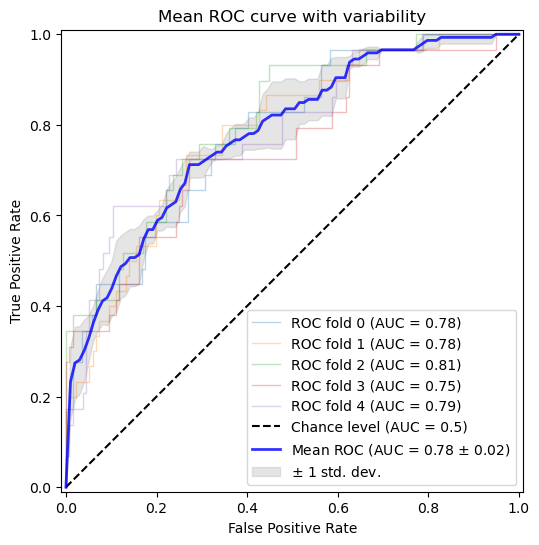

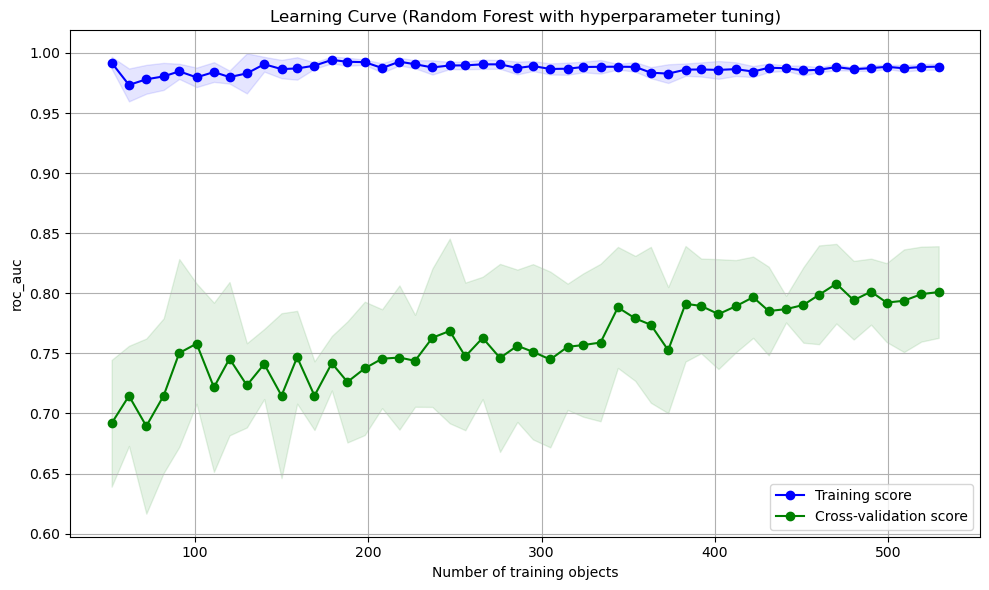

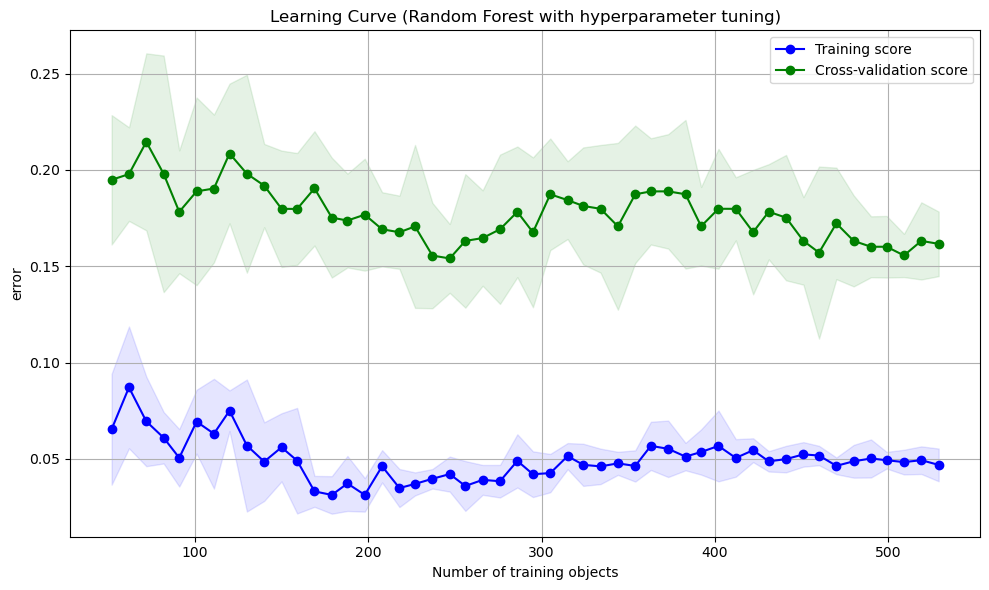

In [54]:
# Original model with 2500 features, from the learning curves it can be seen that this model is too complex 
# and thus overfits on the training data

def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(100, 2500, 25), # [300, 400, 500, 9000],
        'classifier__n_estimators': np.arange(10, 40, 2), # [30, 40, 50],
        'classifier__min_samples_split': np.arange(10, 20, 2), # [5, 10, 15],
        'classifier__min_samples_leaf': np.arange(10, 20, 2),
        'classifier__max_depth': np.arange(6, 20, 2), # [5, 10, 15, None],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')


Best Parameters: {'feature_selection__k': 350, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 25, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.7906897415631294
Accuracy:  0.729
Precision: 0.300
Recall:    0.414
F1 Score:  0.348
AUC Score: 0.736
Best Parameters: {'feature_selection__k': 350, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 25, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.7665669458848557
Accuracy:  0.729
Precision: 0.364
Recall:    0.667
F1 Score:  0.471
AUC Score: 0.829
Best Parameters: {'feature_selection__k': 900, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 40, 'classifier__min_samples_leaf': 40, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.796277090812392


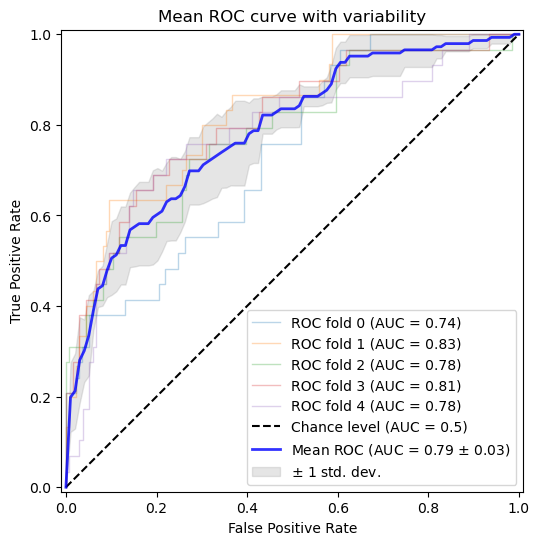

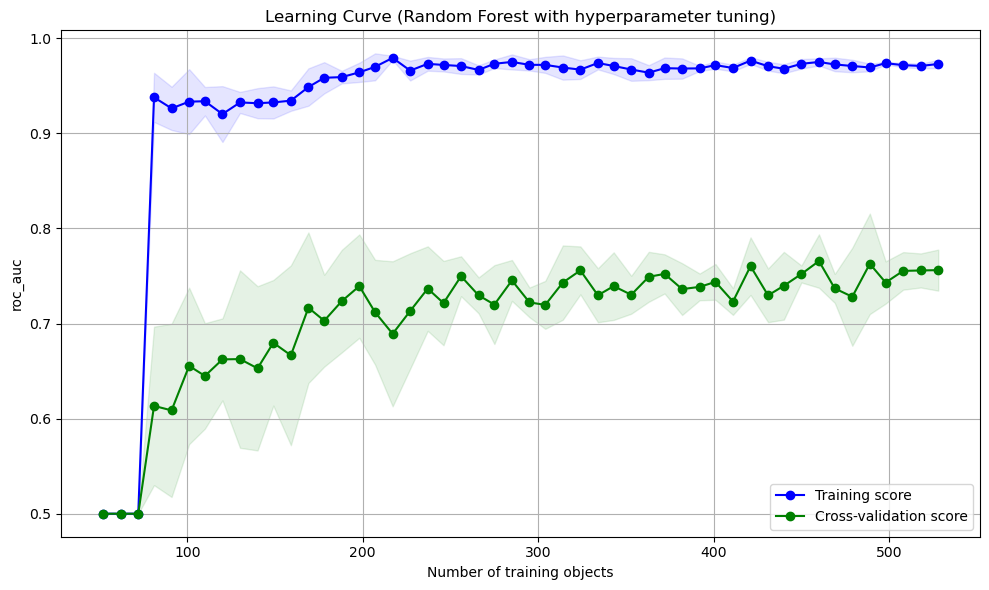

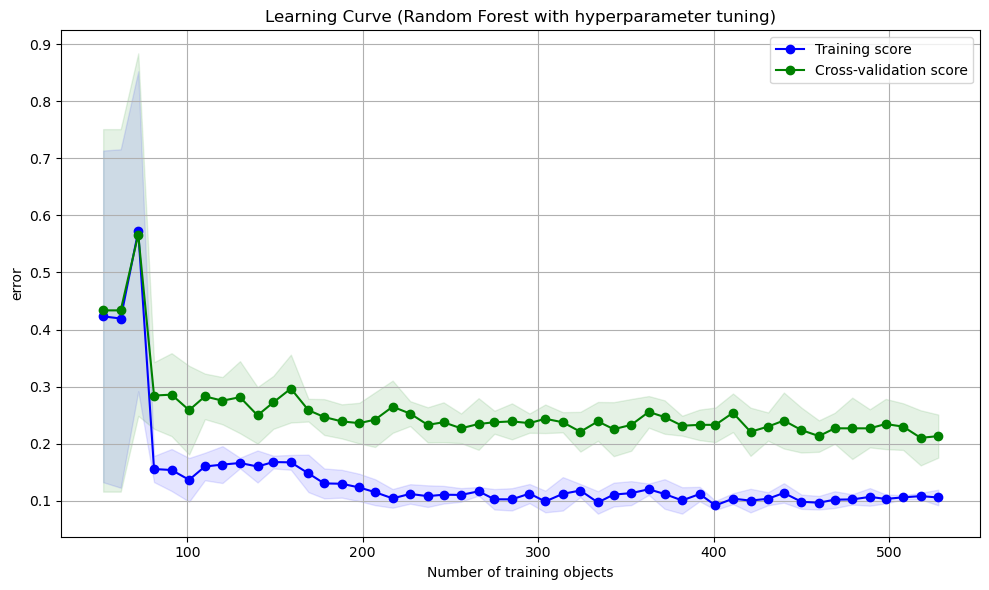

In [55]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(100, 1000, 50),
        'classifier__n_estimators': np.arange(5, 20, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')

Best Parameters: {'feature_selection__k': 110, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 30, 'classifier__min_samples_leaf': 30, 'classifier__min_impurity_decrease': 0.001, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.7738313586156292
Accuracy:  0.813
Precision: 0.472
Recall:    0.586
F1 Score:  0.523
AUC Score: 0.830
Best Parameters: {'feature_selection__k': 160, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 40, 'classifier__min_samples_leaf': 30, 'classifier__min_impurity_decrease': 0.01, 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.7702566148118601
Accuracy:  0.801
Precision: 0.463
Recall:    0.633
F1 Score:  0.535
AUC Score: 0.806
Best Parameters: {'feature_selection__k': 140, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 30, 'classifier__min_impurity_decrease': 

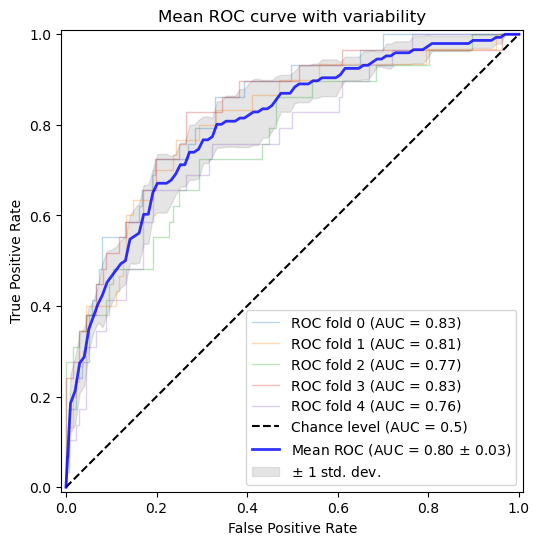

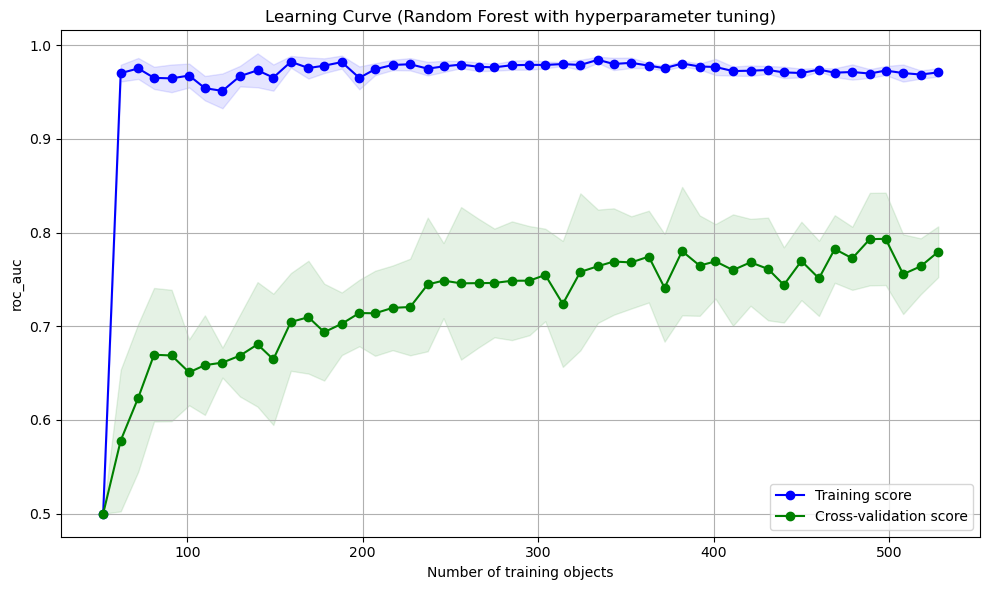

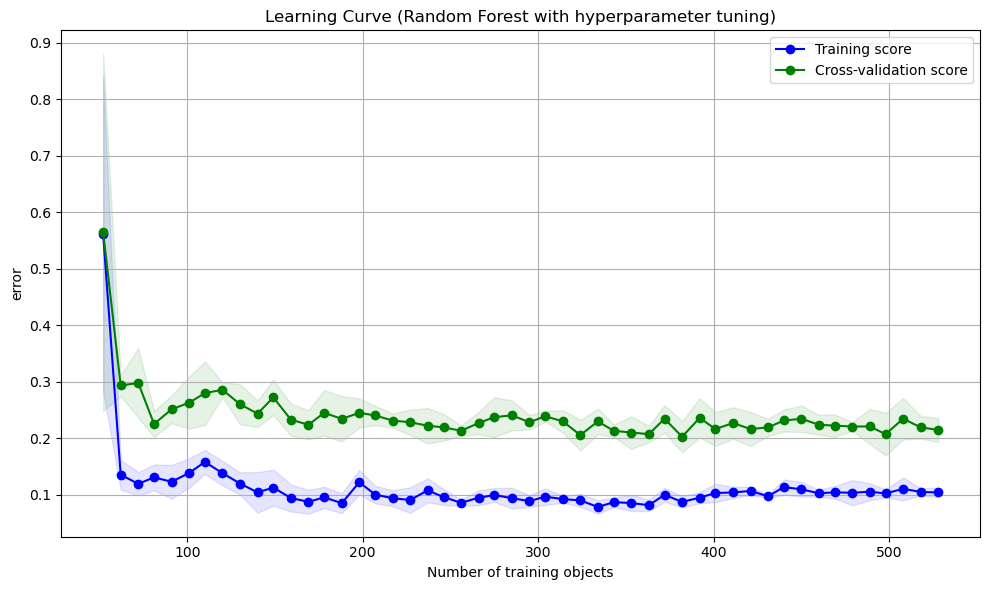

In [56]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(50, 250, 10),
        'classifier__n_estimators': np.arange(5, 20, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False],
        'classifier__min_impurity_decrease': [0.0001, 0.001, 0.01, 0.1]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')